<div style="background-color: #00FF00; padding: 20px;">
    <p style='text-align:center;
              font-family: sans-serif;
              font-weight:bold;
              color:black;
              font-size:50px;
              margin: 5px;'> 
        <font color='blue'; size='7'>Speech Emotion Recognition System</font>
    </p>
    <p style="text-align:center;
              font-family: sans-serif;
              font-weight:bold;
              color:tomato;
              font-size:40px;
              margin: 10px;">
        Extraction Of Acoustic Features
    </p>
</div>

<h1 style="text-align: center; color: WHITE; font-size:30px; background-color: #00FF00; padding: 10px; border-radius: 5px;">
    Project Workflow
</h1>

### 1. Data Preparation
   - Load Audio files
   - Extract Acoustic features

### 2. Model Development
   - Define CNN Model
   - Fit model
   - Plot Training History

### 3. Model Evaluation
   - Make predictions
   - Convert predictions and true labels back to their original form
   - Generate classification report
   - Generate confusion matrix

### 4. Model Deployment
   - Save Model

### 5. User Interface (GUI) Design
   - Design a GUI with Tkinter
   - Create a button to upload the file
   - Create a label to show the prediction result

<h1 style="text-align: center; color: WHITE; background-color: #00FF00; padding: 10px; border-radius: 5px;">
    Part-1: Model Building
</h1>

In [1]:
import numpy as np
import os, glob, pickle

import librosa
import soundfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Feature extraction function
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
    return result


# Load the data and extract features
def load_data(test_size, path):
    x, y = [], []
    for file in glob.glob(path):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    # Normalize the features
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)





def create_cnn_model(input_shape, num_classes):
    """
    Creates and returns a CNN model.

    Parameters:
    - input_shape: tuple, the shape of the input data (timesteps, features).
    - num_classes: int, the number of output classes.

    Returns:
    - model: A compiled Keras Sequential model.
    """
    model = Sequential()

    # Add a Conv1D layer
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Add more Conv1D layers
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Flatten the data for the Dense layers
    model.add(Flatten())

    # Add Dense layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print model summary
    model.summary()

    return model


def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss from the model's history.

    Parameters:
    - history: History object returned by the `fit` method of a Keras model.
    """
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()


def plot_confusion_matrix(conf_matrix, class_labels):
    """
    Plots a confusion matrix using Seaborn's heatmap.

    Parameters:
    - conf_matrix: The confusion matrix (a 2D array) to be plotted.
    - class_labels: List of class labels to be displayed on the axes.
    """
    plt.figure(figsize=(6,4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [3]:
# Emotions 
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Emotions to observe
observed_emotions = ['calm', 'happy', 'fearful', 'disgust']

# Split the dataset
path = r'C:\Users\USER\SIGNAL PROCESSING\Speech emotion recognition\speech-emotion-recognition-ravdess-data\Actor_*\*.wav'
test_size=0.25
x_train, x_test, y_train, y_test = load_data(test_size, path)
print("\nInitial data shape:", (x_train.shape, x_test.shape))

# Reshape the data for Conv1D
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
print("\nData shapes after Reshaping for Conv1D:", (x_train.shape, x_test.shape))


# Get input shape
input_shape = (x_train.shape[1], 1)
print("\ninput_shape:", input_shape)


# Encode the labels
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.transform(y_test))

# Get No Of Classes
num_classes = y_train.shape[1]
print("\nNo Of Classes:", num_classes, "\n" )

# Define a CNN Model
model = create_cnn_model(input_shape, num_classes) 

# Fit the model
history = model.fit(x_train, y_train, epochs= 200, batch_size=32, validation_data=(x_test, y_test))


Initial data shape: ((576, 180), (192, 180))

Data shapes after Reshaping for Conv1D: ((576, 180, 1), (192, 180, 1))

input_shape: (180, 1)

No Of Classes: 4 



C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 178, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 89, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 87, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5504)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,409,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,467,652 (5.60 MB)

 Trainable params: 1,467,652 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.2598 - loss: 1.4289 - val_accuracy: 0.5365 - val_loss: 1.2604
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3863 - loss: 1.2807 - val_accuracy: 0.5000 - val_loss: 1.2122
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4309 - loss: 1.2028 - val_accuracy: 0.5573 - val_loss: 1.1582
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4590 - loss: 1.1226 - val_accuracy: 0.5312 - val_loss: 1.1025
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4867 - loss: 1.0840 - val_accuracy: 0.5781 - val_loss: 1.0946
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4911 - loss: 1.0979 - val_accuracy: 0.5677 - val_loss: 1.0759
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5294 - loss: 1.0392 - val_accuracy: 0.4479 - val_loss: 1.1790
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5470 - loss: 1.0084 - val_accuracy: 0.

6/6 - 0s - 11ms/step - accuracy: 0.7917 - loss: 1.7574
Test accuracy: 0.7917



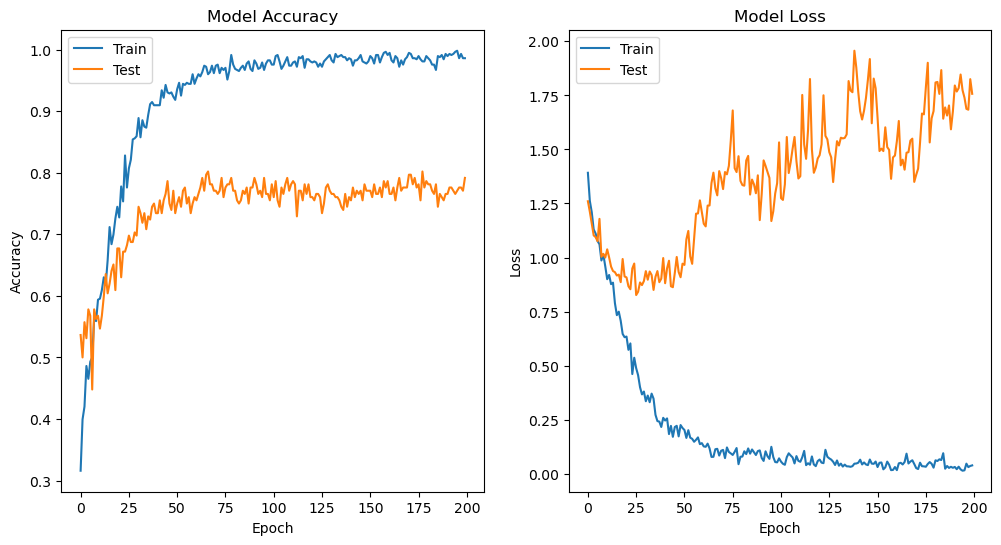

In [4]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.4f}');print()

# plot_training_history(history)
plot_training_history(history)


In [5]:
# Make predictions
y_pred = model.predict(x_test)

# Convert predictions and true labels back to their original form
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=lb.classes_))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Classification Report:

              precision    recall  f1-score   support

        calm       0.96      0.81      0.88        57
     disgust       0.85      0.81      0.83        48
     fearful       0.64      0.86      0.74        37
       happy       0.73      0.70      0.71        50

    accuracy                           0.79       192
   macro avg       0.79      0.80      0.79       192
weighted avg       0.81      0.79      0.80       192



In [6]:
model.save('speech_emotion_recognition_model.h5')  # Save the entire model
print("Model saved successfully as 'speech_emotion_recognition_model.h5'")


Model saved successfully as 'speech_emotion_recognition_model.h5'
